In [1]:
import pandas as pd
import numpy as np

import sys
import os

from pathlib import Path
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Loading


In [4]:
Emofilm = 'D:/Documents/emofilm/data/wav_corpus/'

In [5]:
fear_label = 'fear'
contempt_label = 'contempt'
happiness_label = 'happiness'
anger_label = 'anger'
sadness_label = 'sadness'
neutral_label = 'neutral'
surprise_label = 'surprise'

In [6]:
emofilm_info_df = pd.read_csv('D:/Documents/emofilm/data/complete_info.csv')
emofilm_info_df.head(2)

,file,speaker,film,emotion,language,transcritpion
0,f_ans001aen,Meryl Streep,the hours,ans,en,"[non-verbal] I don't know what's happening, I'..."
1,f_ans001aes,Rosa Guiñón,the hours,ans,es,"No sé lo que me pasa, lo siento."


In [7]:
emofilm_emotions = {
    'ans': fear_label,
    'dis': contempt_label,
    'gio': happiness_label,
    'rab': anger_label,
    'tri': sadness_label
}

# file_emotion = []
# file_path = []
emofilm_map = {'emotion': [], 'path': []}
for index, row in emofilm_info_df.iterrows():
    emofilm_map['emotion'].append(emofilm_emotions.get(row.emotion))
    emofilm_map['path'].append(os.path.join(Emofilm, row.file) + '.wav')


emofilm_df = pd.DataFrame(emofilm_map)
emofilm_df.head(2)

,emotion,path
0,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...
1,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...


In [8]:
data_df = pd.concat([emofilm_df], axis=0)
data_df.head()

,emotion,path
0,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...
1,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...
2,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...
3,fear,D:/Documents/emofilm/data/wav_corpus/f_ans002a...
4,fear,D:/Documents/emofilm/data/wav_corpus/f_ans002a...


## Data Preparation


In [9]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data


def invert_polarity(data):
    return data * -1


def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5)*1000)
    return np.roll(data, shift_range)


def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


# taking any example and checking for techniques.
path = np.array(data_df.path)[1]
data, sample_rate = librosa.load(path)

feature extraction functions


In [11]:
def extract_zcr(data):
    return librosa.feature.zero_crossing_rate(y=data)


def extract_chroma_stft(data, sr):
    return librosa.feature.chroma_stft(y=data, sr=sr)


def extract_mfcc(data, sr):
    return librosa.feature.mfcc(y=data, sr=sr)


def extract_rms(data):
    return librosa.feature.rms(y=data)


def extract_melspectrogram(data, sr):
    return librosa.feature.melspectrogram(y=data, sr=sr, n_fft=512)

In [12]:
# This code was adapted from Nicolas Gervais on https://stackoverflow.com/questions/59241216/padding-numpy-arrays-to-a-specific-size on 1/10/2021
from numpy import ndarray


def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2, 0)
    aa = max(0, xx - a - h)
    b = max(0, (yy - w) // 2)
    bb = max(yy - b - w, 0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')


def fix_length(data: ndarray, length: int):
    fixed = data.reshape(len(data), 1)
    fixed = padding(fixed, length, 1)
    fixed = fixed.reshape(len(fixed))

    return fixed

In [13]:
data_df.head(2)

,emotion,path
0,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...
1,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...


In [41]:
max_length = 110250
max_i = 14
sample_rate = 22050
max_duration_s = librosa.get_duration(path=data_df['path'][14])
required_duration_millis = 5000

width = 216  # 5 seconds of adio is 216
height = 128  # melspectrogram height is 128

duration = int(required_duration_millis/1000*sample_rate)

110250

In [37]:
a, sr = librosa.load(data_df['path'][2])
print(a.shape, sr)

(54860,) 22050


In [39]:
width2 = int(required_duration_millis/1000*sr)
width2

110250

In [26]:
required_audio_size = 5  # audio of size 2 second needs to be padded to 5 seconds
# mono=True converts stereo audio to mono
# padded_audio = librosa.util.fix_length(
#     a, size=int(required_duration_millis/1000*sr))

padded_audio = fix_length(a, width2)

print('Array length before padding', np.shape(a))
print('Audio length before padding in seconds', (np.shape(a)[0]/sr))
print('Array length after padding', np.shape(padded_audio))
print('Audio length after padding in seconds', (np.shape(padded_audio)[0]/sr))
Audio(data=padded_audio, rate=sr)

Array length before padding (54860,)
Audio length before padding in seconds 2.487981859410431
Array length after padding (110250,)
Audio length after padding in seconds 5.0


In [27]:
# p2 = fix_length(a, width2)

# print('Array length after padding2', np.shape(p2))
# print('Audio length after padding2 in seconds', (np.shape(p2)[0]/sr))
# Audio(data=p2, rate=sr)

In [28]:
def get_features_shapes(data, sample_rate):
    print('extract_zcr ', extract_zcr(data).shape)
    print('extract_chroma_stft ', extract_chroma_stft(data, sample_rate).shape)
    print('extract_mfcc ', extract_mfcc(data, sample_rate).shape)
    print('extract_rms ', extract_rms(data).shape)
    print('extract_melspectrogram ',
          extract_melspectrogram(data, sample_rate).shape)
    print('spectral_bandwidth ', librosa.feature.spectral_bandwidth(
        y=data, sr=sample_rate).shape)
    print('spectral_centroid ', librosa.feature.spectral_centroid(
        y=data, sr=sample_rate).shape)

In [29]:
get_features_shapes(a, sr)

extract_zcr  (1, 108)
extract_chroma_stft  (12, 108)
extract_mfcc  (20, 108)
extract_rms  (1, 108)
extract_melspectrogram  (128, 108)
spectral_bandwidth  (1, 108)
spectral_centroid  (1, 108)


In [30]:
# extract_zcr(a)
# extract_chroma_stft(a, sr)
# extract_mfcc(a, sr)
# extract_rms(a)
# extract_melspectrogram(a, sr)

# result = extract_features(a)
# result.shape

(20, 216)


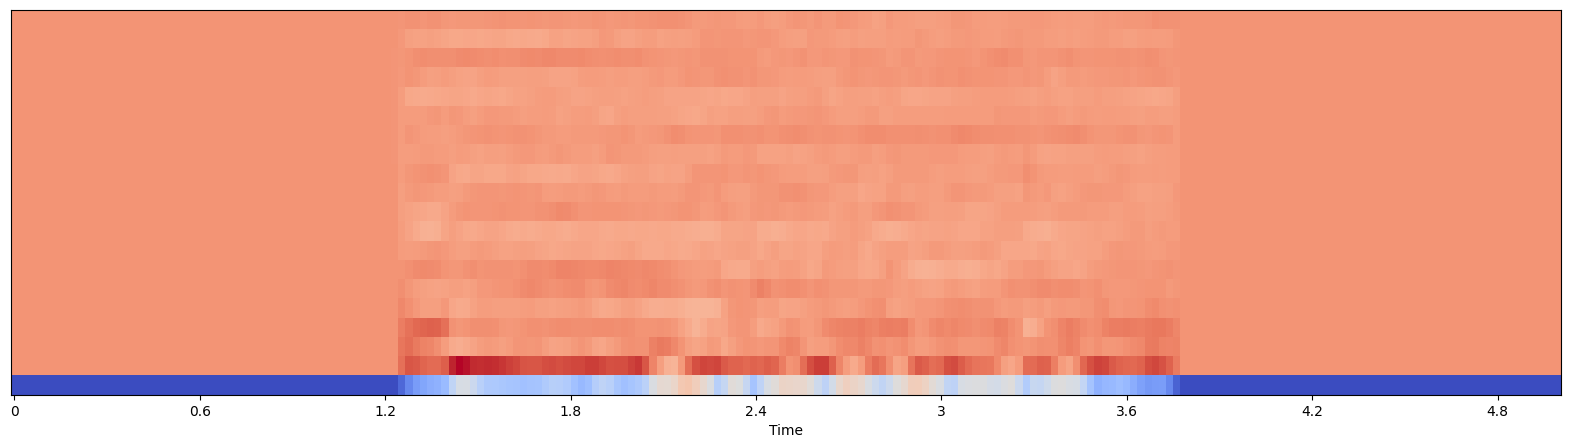

In [31]:
# MFCC
plt.figure(figsize=(20, 5))
mfccs = librosa.feature.mfcc(y=padded_audio, sr=sr)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=sr, x_axis='time')

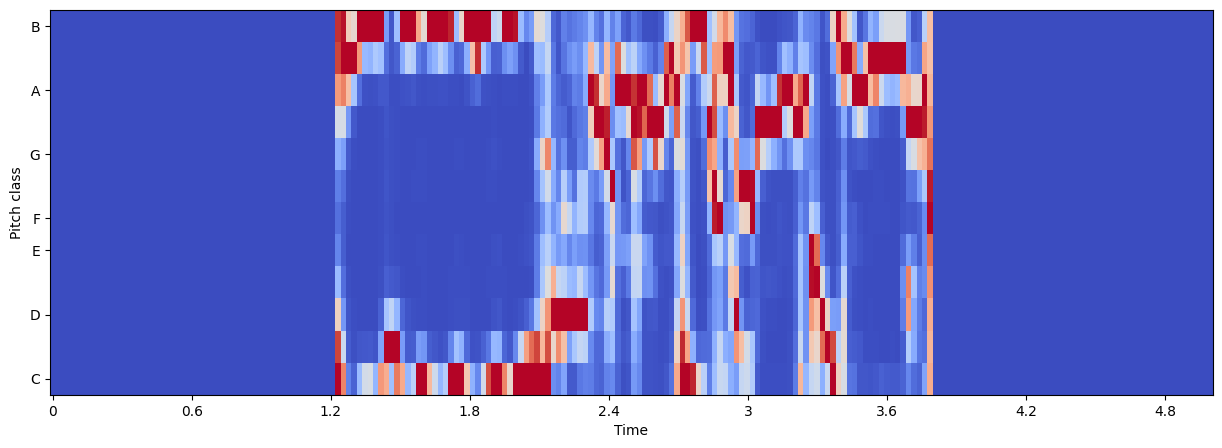

In [32]:
hop_length = 512
S = np.abs(librosa.stft(a))
chromagram = librosa.feature.chroma_stft(
    y=padded_audio, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time',
                         y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

In [33]:
print(mfccs.shape, chromagram.shape)

(20, 216) (12, 216)


In [34]:
from sklearn.preprocessing import normalize


def generate_features(y_cut):
    max_size = 200  # my max audio file feature width
    stft = padding(
        np.abs(librosa.stft(y_cut, n_fft=255, hop_length=512)), 128, max_size)
    MFCCs = padding(librosa.feature.mfcc(y=y_cut,
                    hop_length=hop_length, n_mfcc=128), 128, max_size)
    spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)
    # Now the padding part
    image = np.array([padding(normalize(spec_bw), 1, max_size)]
                     ).reshape(1, max_size)
    image = np.append(image, padding(
        normalize(spec_centroid), 1, max_size), axis=0)
    # repeat the padded spec_bw,spec_centroid and chroma stft until they are stft and MFCC-sized
    for i in range(0, 9):
        image = np.append(image, padding(
            normalize(spec_bw), 1, max_size), axis=0)
        image = np.append(image, padding(
            normalize(spec_centroid), 1, max_size), axis=0)
        image = np.append(image, padding(
            normalize(chroma_stft), 12, max_size), axis=0)
    image = np.dstack((image, np.abs(stft)))
    image = np.dstack((image, MFCCs))
    return image


def generate_features_spectrogram(data):
    spec_bw = librosa.feature.spectral_bandwidth(y=data, sr=sr)
    spec_centroid = librosa.feature.spectral_centroid(y=data, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=data, sr=sr)
    zcr = extract_zcr(data=data)
    rms = extract_rms(data=data)

    stft = np.abs(librosa.stft(data, n_fft=255, hop_length=512))
    MFCCs = librosa.feature.mfcc(
        y=data, hop_length=hop_length, n_mfcc=height)
    mels = extract_melspectrogram(data=data, sr=sr)

    image = generate_image(spec_bw, spec_centroid, zcr,
                           rms, chroma_stft, stft, MFCCs)

    return image


def generate_image(spec_bw, spec_centroid, zcr, rms, chroma_stft, stft, MFCCs, img_height=128, use_normalize=True):
    image_width = spec_bw.shape[1]

    image = np.zeros((0, image_width))

    for i in range(0, 8):
        image = np.append(image, padding(
            normalize(spec_bw), 1, image_width), axis=0)
        image = np.append(image, padding(
            normalize(spec_centroid), 1, image_width), axis=0)
        image = np.append(image, padding(
            normalize(zcr), 1, image_width), axis=0)
        image = np.append(image, padding(
            normalize(rms), 1, image_width), axis=0)
        image = np.append(image, padding(
            normalize(chroma_stft), 12, image_width), axis=0)

    if (image.shape[0] != img_height or stft.shape[0] != img_height or MFCCs.shape[0] != img_height):
        print(
            f'Incorrect sizes\nimage.shape={image.shape}\tstft.shape={stft.shape}\tMFCCs.shape={MFCCs.shape}')
        return image

    if (use_normalize):
        stft = padding(
            normalize(stft), img_height, image_width)
        MFCCs = padding(
            normalize(MFCCs), img_height, image_width)

    image = np.dstack((image, stft))
    image = np.dstack((image, MFCCs))

    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


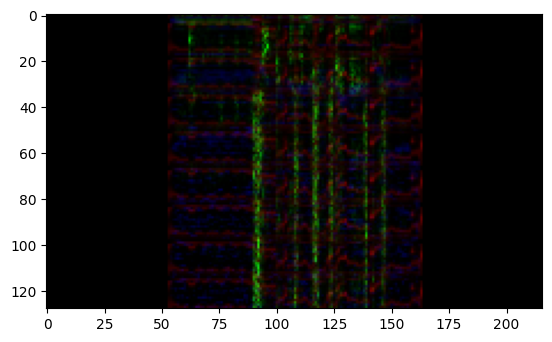

In [35]:
image2 = generate_features_spectrogram(padded_audio)
plt.imshow(image2)

In [49]:
image2.shape

(128, 216, 3)

## Feature extraction


get features from all files


In [36]:
data_df.head(2)

,emotion,path
0,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...
1,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...


In [164]:
from pandas import DataFrame

duration = int(required_duration_millis/1000*sample_rate)


def get_features(data: DataFrame):
    features = []
    labels = []

    for i, row in data.iterrows():
        # load audio
        audio, sr = librosa.load(row['path'])
        audio = fix_length(audio, duration)
        # get spectrogram
        image = generate_features_spectrogram(audio)
        # add to features
        features.append(image[np.newaxis, ...])
        # add label
        labels.append(row['emotion'])

    # return result
    result = np.concatenate(features, axis=0)
    return (np.array(result), labels)

In [188]:
X = data_df['path']
y = data_df['emotion']

In [189]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1, 1)).toarray()

In [190]:
# Split once to get the test and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_val.shape)

(780,) (335,)


In [191]:
# Split once to get the test and validation set
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.3, random_state=42)
print(X_val.shape, X_test.shape)

(234,) (101,)


In [154]:
print(f'train: {X_train.shape}\ntest: {X_test.shape}\nval: {X_val.shape}')

train: (780,)
test: (101,)
val: (234,)


In [155]:
train_df = pd.DataFrame(list(zip(y_train, X_train)),
                        columns=['emotion', 'path'])
test_df = pd.DataFrame(list(zip(y_test, X_test)), columns=['emotion', 'path'])
val_df = pd.DataFrame(list(zip(y_val, X_val)), columns=['emotion', 'path'])

In [156]:
train_features, train_labels = get_features(train_df)
test_features, test_labels = get_features(test_df)
val_features, val_labels = get_features(val_df)

In [186]:
test_df  # use y_test for now

,emotion,path
0,"[0.0, 0.0, 0.0, 1.0, 0.0]",D:/Documents/emofilm/data/wav_corpus/m_gio049a...
1,"[0.0, 0.0, 1.0, 0.0, 0.0]",D:/Documents/emofilm/data/wav_corpus/f_ans042b...
2,"[1.0, 0.0, 0.0, 0.0, 0.0]",D:/Documents/emofilm/data/wav_corpus/m_rab096b...
3,"[0.0, 0.0, 1.0, 0.0, 0.0]",D:/Documents/emofilm/data/wav_corpus/m_ans003c...
4,"[0.0, 0.0, 1.0, 0.0, 0.0]",D:/Documents/emofilm/data/wav_corpus/f_ans102a...
...,...,...
96,"[1.0, 0.0, 0.0, 0.0, 0.0]",D:/Documents/emofilm/data/wav_corpus/m_rab102b...
97,"[0.0, 0.0, 0.0, 1.0, 0.0]",D:/Documents/emofilm/data/wav_corpus/m_gio046a...
98,"[0.0, 0.0, 0.0, 1.0, 0.0]",D:/Documents/emofilm/data/wav_corpus/m_gio003a...
99,"[1.0, 0.0, 0.0, 0.0, 0.0]",D:/Documents/emofilm/data/wav_corpus/m_rab070a...


In [159]:
print(f'train: {train_features.shape, len(train_labels)}\ntest: {test_features.shape, len(test_labels)}\nval: {val_features.shape, len(val_labels)}')

train: ((780, 128, 216, 3), 780)
test: ((101, 128, 216, 3), 101)
val: ((234, 128, 216, 3), 234)


In [192]:
y_val.shape

(234, 5)

## Modeling


In [86]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

print(tf.config.list_physical_devices('GPU'))

[]


In [100]:
input_shape = (128, 216, 3)
CNNmodel = Sequential()
CNNmodel.add(Conv2D(
    32, (3, 3), activation='relu', input_shape=input_shape))
CNNmodel.add(MaxPooling2D((2, 2)))
CNNmodel.add(Dropout(0.2))
CNNmodel.add(Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(MaxPooling2D((2, 2)))
CNNmodel.add(Dropout(0.2))
CNNmodel.add(Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(Flatten())
CNNmodel.add(Dense(64, activation='relu'))
CNNmodel.add(Dropout(0.2))
CNNmodel.add(Dense(32, activation='relu'))
CNNmodel.add(Dense(units=5, activation='softmax'))

In [181]:
CNNmodel.compile(optimizer='adam',
                 loss='categorical_crossentropy', metrics=['accuracy'])

CNNmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 214, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 107, 32)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 63, 107, 32)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 105, 64)       18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 52, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 30, 52, 64)       

In [182]:
epochs_num = 10

In [183]:
y_train.shape

(780, 5)

In [193]:
history = CNNmodel.fit(train_features, y_train, epochs=epochs_num,
                       validation_data=(val_features, y_val))

Epoch 1/10
25/25 [==============================] - 14s 549ms/step - loss: 1.5857 - accuracy: 0.2846 - val_loss: 1.5699 - val_accuracy: 0.2692
Epoch 2/10
25/25 [==============================] - 14s 547ms/step - loss: 1.5644 - accuracy: 0.2590 - val_loss: 1.5656 - val_accuracy: 0.2607
Epoch 3/10
25/25 [==============================] - 12s 495ms/step - loss: 1.4764 - accuracy: 0.3679 - val_loss: 1.5795 - val_accuracy: 0.2521
Epoch 4/10
25/25 [==============================] - 12s 493ms/step - loss: 1.2835 - accuracy: 0.4577 - val_loss: 1.4216 - val_accuracy: 0.3932
Epoch 5/10
25/25 [==============================] - 14s 546ms/step - loss: 0.9866 - accuracy: 0.6192 - val_loss: 1.4280 - val_accuracy: 0.4188
Epoch 6/10
25/25 [==============================] - 15s 609ms/step - loss: 0.7492 - accuracy: 0.7321 - val_loss: 1.5272 - val_accuracy: 0.4017
Epoch 7/10
25/25 [==============================] - 15s 614ms/step - loss: 0.4863 - accuracy: 0.8218 - val_loss: 1.7476 - val_accuracy: 0.4231

In [ ]:
print("Accuracy of our model on test data : ",
      CNNmodel.evaluate(test_labels, y_test)[1]*100, "%")


epochs = [i for i in range(epochs_num)]

fig, ax = plt.subplots(1, 2)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.show()

In [ ]:
# predicting on test data.
pred_test = CNNmodel.predict(test_features)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(test_labels)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[
                  i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues',
            linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

## Stuff


get features -- old


In [145]:
spec_bw = librosa.feature.spectral_bandwidth(y=padded_audio, sr=sr)
spec_centroid = librosa.feature.spectral_centroid(y=padded_audio, sr=sr)
chroma_stft = librosa.feature.chroma_stft(y=padded_audio, sr=sr)
zcr = extract_zcr(data=padded_audio)
rms = extract_rms(data=padded_audio)

stft = np.abs(librosa.stft(padded_audio, n_fft=255, hop_length=512))
MFCCs = librosa.feature.mfcc(
    y=padded_audio, hop_length=hop_length, n_mfcc=height)
mels = extract_melspectrogram(data=padded_audio, sr=sr)

print(spec_bw.shape, spec_centroid.shape,
      chroma_stft.shape, zcr.shape, rms.shape, stft.shape, MFCCs.shape, mels.shape)

(1, 216) (1, 216) (12, 216) (1, 216) (1, 216) (128, 216) (128, 216) (128, 216)


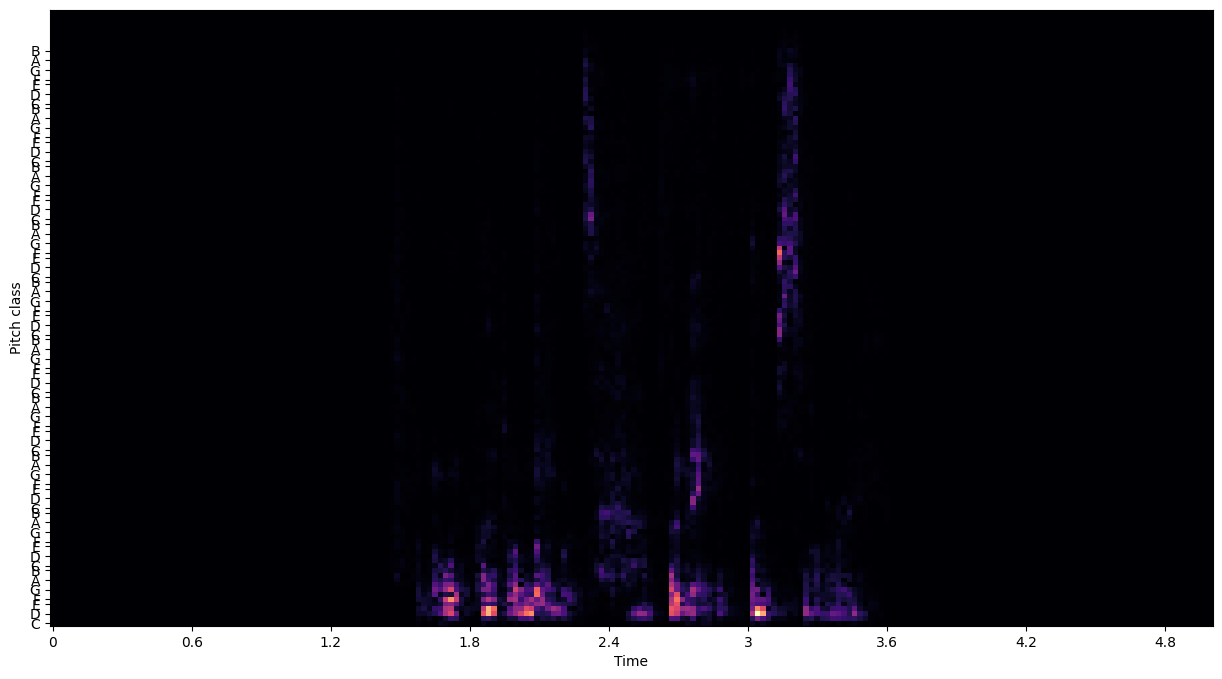

In [133]:
plt.figure(figsize=(15, 8))
librosa.display.specshow(stft, x_axis='time',
                         y_axis='chroma', hop_length=512)
plt.show()

add padding to features -- skip (use padded audio to extract features in first place)


In [106]:
# spec_bw = padding(spec_bw, 1, width)
# spec_centroid = padding(spec_centroid, 1, width)
# chroma_stft = padding(chroma_stft, 1, width)
# zcr = padding(zcr, 1, width)
# rms = padding(rms, 1, width)

# stft = padding(stft, height, width)
# MFCCs = padding(MFCCs, height, width)
# mels = padding(mels, height, width)


# print(spec_bw.shape, spec_centroid.shape,
#       chroma_stft.shape, zcr.shape, rms.shape, stft.shape, MFCCs.shape, mels.shape)

(1, 216) (1, 216) (12, 216) (1, 216) (1, 216) (300, 216) (128, 216) (128, 216)


In [72]:
plt.figure(figsize=(10, 5))
librosa.display.specshow(stft, x_axis='time',
                         y_axis='linear', hop_length=512)
plt.show()

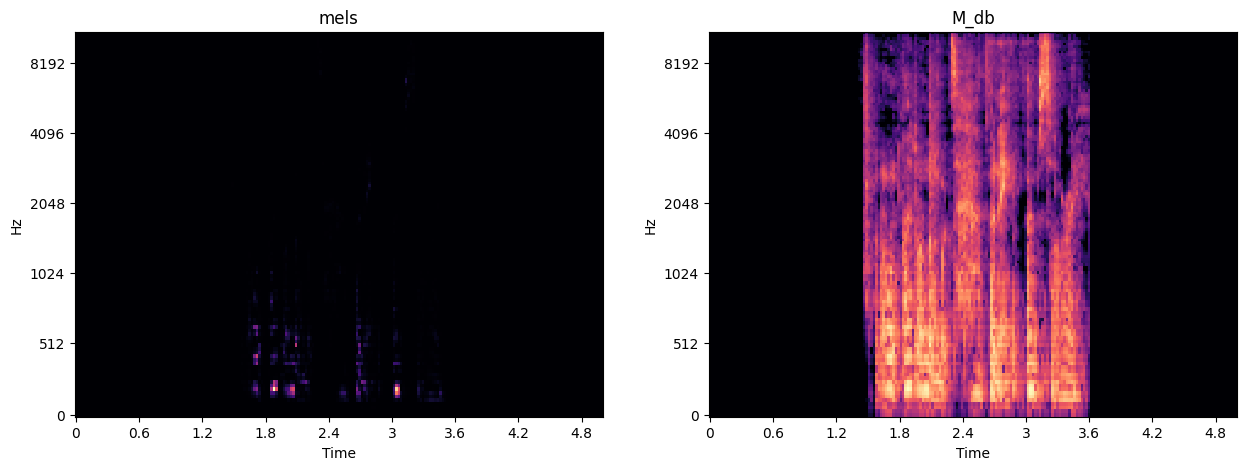

In [73]:
M_db = librosa.power_to_db(mels, ref=np.max)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# plt.figure(figsize=(10, 5))

librosa.display.specshow(mels, x_axis='time', ax=ax1,
                         y_axis='mel', hop_length=512)
librosa.display.specshow(M_db, x_axis='time', ax=ax2,
                         y_axis='mel', hop_length=512)
ax1.set_title('mels')
ax2.set_title('M_db')
plt.show()

combine features into image with 3 layers


128 / 16 = 8 -> features 8 times to match mfccs and features height


In [88]:
print(spec_bw.shape, spec_centroid.shape,
      chroma_stft.shape, zcr.shape, rms.shape)

image_width = spec_bw.shape[1]
print(width, width2, image_width)

(1, 216) (1, 216) (12, 216) (1, 216) (1, 216)
250 110250 216


In [161]:
image = np.zeros((0, 216))

for i in range(0, 8):
    image = np.append(image, padding(
        normalize(spec_bw), 1, image_width), axis=0)
    image = np.append(image, padding(
        normalize(spec_centroid), 1, image_width), axis=0)
    image = np.append(image, padding(
        normalize(zcr), 1, image_width), axis=0)
    image = np.append(image, padding(
        normalize(rms), 1, image_width), axis=0)
    image = np.append(image, padding(
        normalize(chroma_stft), 12, image_width), axis=0)

image.shape

(128, 216)

In [162]:
image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

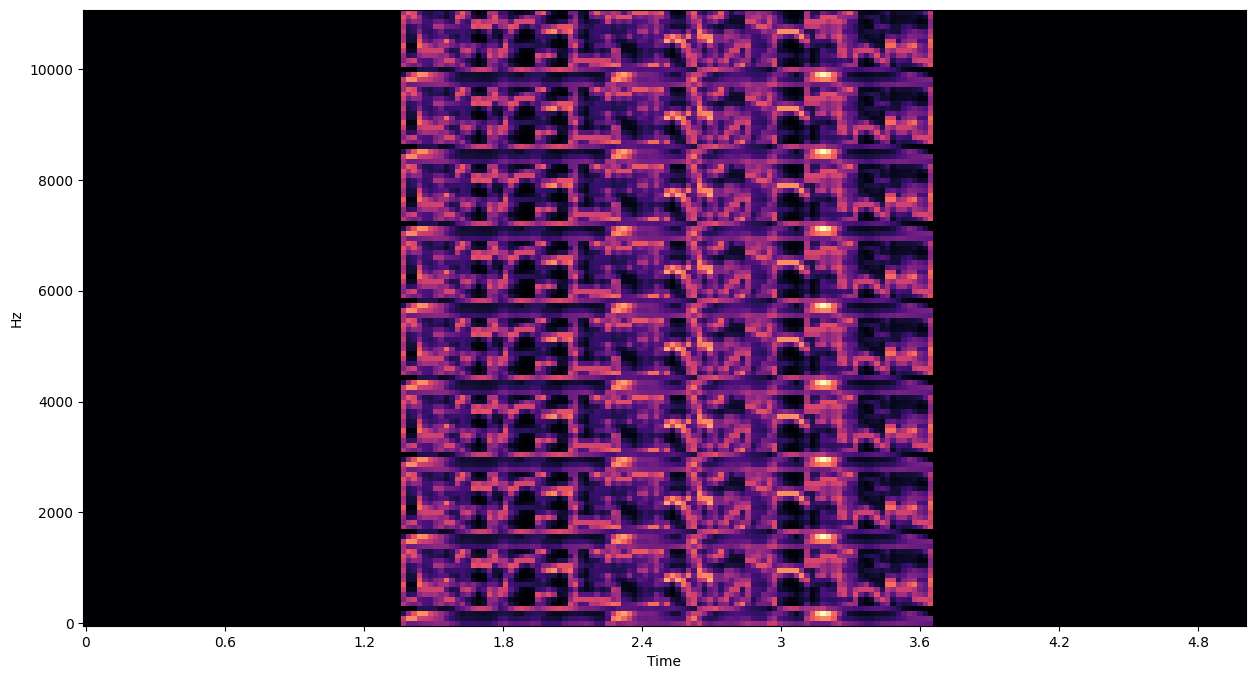

In [163]:
plt.figure(figsize=(15, 8))
librosa.display.specshow(image, x_axis='time',
                         y_axis='linear', hop_length=512)
plt.show()

Combine into single image


In [164]:
stft_n = padding(
    normalize(stft), 128, image_width)

MFCCs_n = padding(
    normalize(MFCCs), 128, image_width)

image = np.dstack((image, stft_n))
image = np.dstack((image, MFCCs_n))

In [165]:
# image = np.dstack((image, stft))
# image = np.dstack((image, MFCCs))

In [166]:
image.shape

(128, 216, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


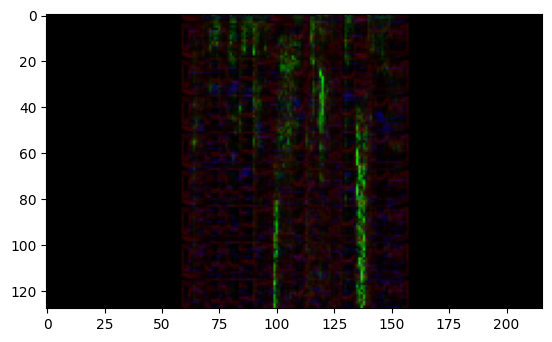

In [167]:
plt.imshow(image)

Something else...


In [ ]:
image = np.array([padding(normalize(spec_bw), 1, 200)]).reshape(1, width)

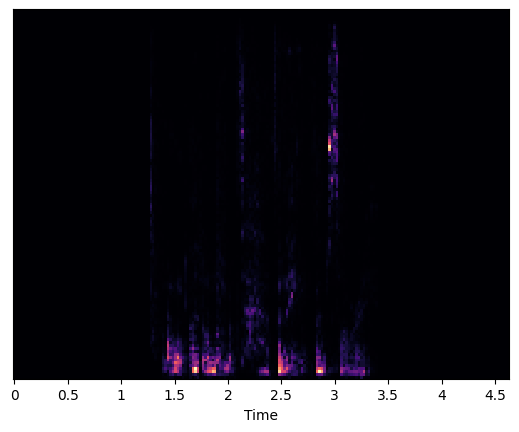

In [82]:
stft = padding(
    np.abs(librosa.stft(a, n_fft=255, hop_length=512)), 128, 200)
librosa.display.specshow(stft, sr=sr, x_axis='time')

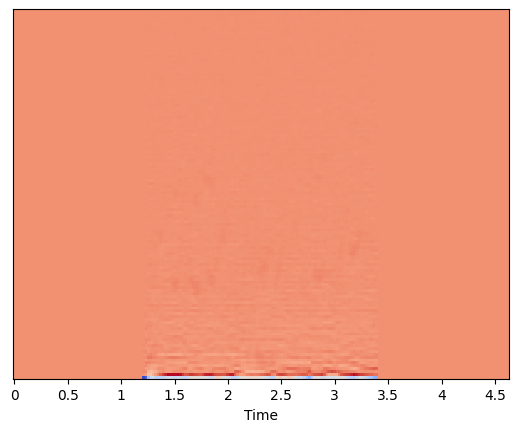

In [91]:
MFCCs = padding(librosa.feature.mfcc(y=a,
                                     hop_length=hop_length, n_mfcc=128), 128, 200)
librosa.display.specshow(MFCCs, sr=sr, x_axis='time')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


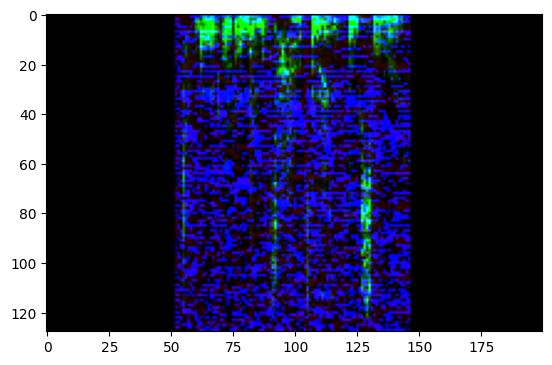

In [98]:
test = generate_features(a)
plt.imshow(test)

In [ ]:
# X, Y = [], []
# for path, emotion in zip(data_df.path, data_df.emotion):
#     features = get_features(path)
#     for ele in features:
#         X.append(ele)
#         Y.append(emotion)

# Features = pd.DataFrame(X)
# Features['labels'] = Y
# # Features.to_csv('features.csv', index=False)
# Features.head()